In [367]:
from sklearn.datasets import make_blobs, make_circles, make_moons
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as sl
from collections import deque

In [368]:
# Defining parameters (has to be fine-tunned for every case)
overlap_thershold = 0.7
gaussian_width = 3.0

In [369]:
X, y = make_moons(n_samples=100, noise=0.06, random_state=1)

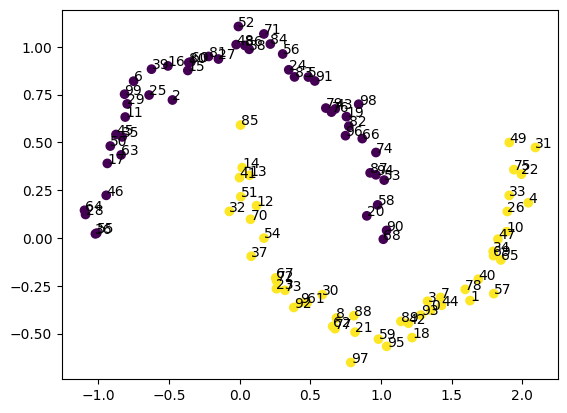

In [370]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X[:,0], X[:,1], c=y)
for i in range(X.shape[0]):
  plt.annotate(str(i), (X[i,0], X[i,1]))
plt.show()

In [371]:
def overlap_f(Ra, Rb, a, b) -> float:
  c1 = (np.pi / (a + b)) ** (3/2)
  k1 = -a*b/(a+b)
  k2 = np.linalg.norm(Ra - Rb) ** 2
  c2 = np.exp(k1 * k2)
  return c2 * c2

In [372]:
overlap_m = np.empty((X.shape[0], X.shape[0]))
g_width = np.random.uniform(low=gaussian_width, high=gaussian_width, size=(X.shape[0]))

In [373]:
for i in range(X.shape[0]):
  for j in range(X.shape[0]):
    overlap_m[i,j] = overlap_f(X[i,:], X[j,:], g_width[i], g_width[j])

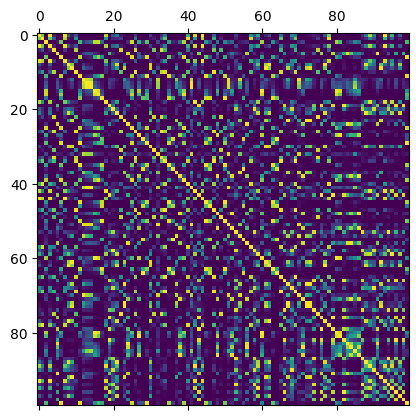

In [374]:
plt.matshow(overlap_m)

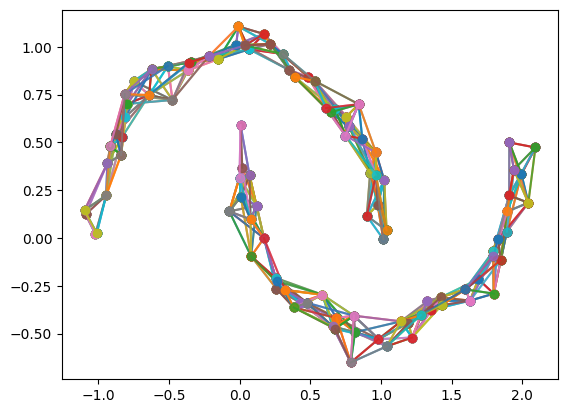

In [375]:
B = np.zeros((X.shape[0], X.shape[0]), dtype=int)
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X[:,0], X[:,1])
for i in range(X.shape[0]):
  for j in range(X.shape[0]):
    if i == j:
      continue
    elif overlap_m[i,j] > overlap_thershold:
      x_values = [X[i,0], X[j,0]]
      y_values = [X[i,1], X[j,1]]
      ax.plot(x_values, y_values, marker='o', alpha=overlap_m[i,j])
      B[i,j] = 1
    else:
      B[i,j] = 0
plt.show()

In [376]:
D = np.diag(np.sum(B, axis=0))

In [377]:
L = D - B + np.identity(D.shape[0])*1.0e-8

In [378]:
_ = sl.cholesky(L)  # If the Cholesky factorization doesn't work, it wont work.

In [379]:
V = X.shape[0]
visited = [False] * V
categories = np.zeros((V,), dtype=int) # 0 for noise, not connected point, 1, 2, ... for clusters

In [380]:
current_category = 1
for i in range(V):
  if not visited[i]:
    visited[i] = True
    if D[i,i] < 1:
      # We have an unconnected point, nothing to do here
      categories[i] = 0
      continue
    else:
      # It is a connected point, let's go
      q = deque()
      q.append(i)
      while q:
        curr = q.popleft()
        categories[curr] = current_category

        linked_nodes = np.where(B[:,curr] > 0)[0]
        for x in linked_nodes:
          if not visited[x]:
            visited[x] = True
            q.append(x)
            categories[x] = current_category

    current_category += 1


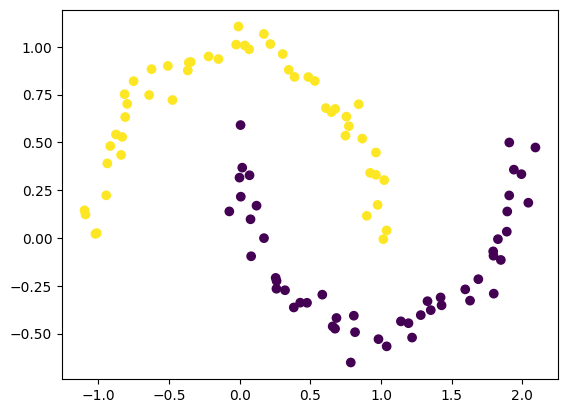

In [381]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X[:, 0], X[:, 1], c=categories)
plt.show()

In [382]:
from sklearn.metrics import (
    adjusted_mutual_info_score,
    adjusted_rand_score,
    completeness_score,
    fowlkes_mallows_score
)

In [383]:
print(f"Adjusted Mutual Information between predicted and original (1 for perfect matching, 0 for uncorrelated):                              {adjusted_mutual_info_score(y, categories)}")
print(f"Rand index adjusted for chance between predicted and original (1 for perfect matching, 0 for uncorrelated, <0 for highly discordant): {adjusted_rand_score(y, categories)}")
print(f"Completeness metric of a cluster labeling given a ground truth and predicted (1 for perfect matching, 0 for unmatched clusters):      {completeness_score(y, categories)}")
print(f"Fowlkes-Mallows index (FMI) between predicted and truth (1 for perfect matching, 0 for unmatched clusters):                           {fowlkes_mallows_score(y, categories)}")

Adjusted Mutual Information between predicted and original (1 for perfect matching, 0 for uncorrelated):                              1.0
Rand index adjusted for chance between predicted and original (1 for perfect matching, 0 for uncorrelated, <0 for highly discordant): 1.0
Completeness metric of a cluster labeling given a ground truth and predicted (1 for perfect matching, 0 for unmatched clusters):      1.0
Fowlkes-Mallows index (FMI) between predicted and truth (1 for perfect matching, 0 for unmatched clusters):                           1.0
